# Relation-PCA on Embeddings

### **Word2Vec**

In [ ]:
import re
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
W2V_HANDLE = "https://tfhub.dev/google/Wiki-words-500-with-normalization/2"  # 500d
K_MAX = 64                      # evaluate nested subspaces k=1..K_MAX
VAR_TARGET = 0.95               # choose k* as smallest k reaching this explained variance
NORMALIZE_ROWS = True           # L2-normalize embeddings before Relation-PCA

# Choose multiple (disjoint) subspaces via deflation:
NUM_SUBSPACES = 3               # number of k-blocks
K_BLOCK = 5                     # dimension per block (so total captured dims = NUM_SUBSPACES * K_BLOCK)

In [ ]:
PAIRS: List[Tuple[str,str]] = [
    ("paris", "france"), ("rome", "italy"), ("madrid", "spain"), ("berlin", "germany"),
    ("lisbon", "portugal"), ("london", "united kingdom"), ("dublin", "ireland"), ("athens", "greece"),
    ("vienna", "austria"), ("brussels", "belgium"), ("amsterdam", "netherlands"), ("luxembourg", "luxembourg"),
    ("bern", "switzerland"), ("oslo", "norway"), ("stockholm", "sweden"), ("copenhagen", "denmark"),
    ("helsinki", "finland"), ("reykjavik", "iceland"), ("tallinn", "estonia"), ("riga", "latvia"),
    ("vilnius", "lithuania"), ("warsaw", "poland"), ("prague", "czechia"), ("bratislava", "slovakia"),
    ("budapest", "hungary"), ("ljubljana", "slovenia"), ("zagreb", "croatia"), ("belgrade", "serbia"),
    ("sarajevo", "bosnia and herzegovina"), ("tirana", "albania"), ("podgorica", "montenegro"), ("skopje", "north macedonia"),
    ("pristina", "kosovo"), ("sofia", "bulgaria"), ("bucharest", "romania"), ("chisinau", "moldova"),
    ("kyiv", "ukraine"), ("minsk", "belarus"), ("moscow", "russia"), ("vatican city", "vatican city"),
    ("valletta", "malta"), ("nicosia", "cyprus"), ("monaco", "monaco"), ("andorra la vella", "andorra"),
    ("san marino", "san marino"), ("ankara", "turkey"), ("tehran", "iran"), ("baghdad", "iraq"),
    ("damascus", "syria"), ("amman", "jordan"), ("beirut", "lebanon"), ("jerusalem", "israel"),
    ("riyadh", "saudi arabia"), ("doha", "qatar"), ("abu dhabi", "united arab emirates"), ("kuwait city", "kuwait"),
    ("manama", "bahrain"), ("muscat", "oman"), ("sanaa", "yemen"), ("kabul", "afghanistan"),
    ("islamabad", "pakistan"), ("new delhi", "india"), ("kathmandu", "nepal"), ("thimphu", "bhutan"),
    ("dhaka", "bangladesh"), ("colombo", "sri lanka"), ("male", "maldives"), ("bangkok", "thailand"),
    ("hanoi", "vietnam"), ("phnom penh", "cambodia"), ("vientiane", "laos"), ("yangon", "myanmar"),
    ("kuala lumpur", "malaysia"), ("singapore", "singapore"), ("jakarta", "indonesia"), ("manila", "philippines"),
    ("dili", "east timor"), ("bandar seri begawan", "brunei"), ("beijing", "china"), ("ulaanbaatar", "mongolia"),
    ("pyongyang", "north korea"), ("seoul", "south korea"), ("tokyo", "japan"), ("cairo", "egypt"),
    ("tripoli", "libya"), ("tunis", "tunisia"), ("algiers", "algeria"), ("rabat", "morocco"),
    ("nouakchott", "mauritania"), ("bamako", "mali"), ("niamey", "niger"), ("ndjamena", "chad"),
    ("khartoum", "sudan"), ("addis ababa", "ethiopia"), ("djibouti", "djibouti"), ("asmara", "eritrea"),
    ("mogadishu", "somalia"), ("nairobi", "kenya"), ("kampala", "uganda"), ("kigali", "rwanda"),
    ("dodoma", "tanzania"), ("bujumbura", "burundi"), ("libreville", "gabon"), ("brazzaville", "republic of the congo"),
    ("kinshasa", "democratic republic of the congo"), ("luanda", "angola"), ("lusaka", "zambia"), ("harare", "zimbabwe"),
    ("maputo", "mozambique"), ("antananarivo", "madagascar"), ("port louis", "mauritius"), ("gaborone", "botswana"),
    ("windhoek", "namibia"), ("pretoria", "south africa"), ("maseru", "lesotho"), ("mbabane", "eswatini"),
    ("lilongwe", "malawi"), ("accra", "ghana"), ("dakar", "senegal"), ("freetown", "sierra leone"),
    ("monrovia", "liberia"), ("abidjan", "cote d'ivoire"), ("ouagadougou", "burkina faso"), ("porto-novo", "benin"),
    ("abja", "nigeria")
]

In [ ]:
# # ====================== Embedding helpers ======================

# def tokenize(text: str) -> List[str]:
#     """Split on non-letters, lowercase, keep a..z tokens."""
#     return [t for t in re.split(r"[^A-Za-z]+", text.lower()) if t]

# class TFHubWord2Vec:
#     """TF-Hub Wiki-words-* embedder. Averages token vectors for multi-token phrases."""
#     def __init__(self, handle: str):
#         self.layer = hub.KerasLayer(handle, trainable=False)  # [batch] -> [batch, d]
#         probe = self.layer(tf.constant(["test"]))
#         self.dim = int(probe.shape[-1])

#     def embed_phrase(self, phrase: str) -> np.ndarray:
#         toks = tokenize(phrase)
#         if not toks:
#             toks = [phrase]
#         vecs = self.layer(tf.constant(toks)).numpy()  # (m, d)
#         return vecs.mean(axis=0)

#     def embed_many(self, phrases: List[str]) -> np.ndarray:
#         return np.vstack([self.embed_phrase(p) for p in phrases]).astype(np.float32)


In [ ]:
# # ====================== Relation-PCA core ======================

# def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
#     """
#     Relation-PCA on centered Δ = V - U using TensorFlow eigendecomposition.
#     Returns eigvectors/values and per-k leakage & variance metrics.
#     """
#     assert U.shape == V.shape, "U and V must have same shape."
#     n, d = U.shape
#     U_tf = tf.convert_to_tensor(U, dtype=tf.float64)
#     V_tf = tf.convert_to_tensor(V, dtype=tf.float64)
#     Delta = V_tf - U_tf
#     Delta = Delta - tf.reduce_mean(Delta, axis=0, keepdims=True)  # center

#     # Covariance and eigendecomposition
#     C = tf.matmul(Delta, Delta, transpose_a=True) / float(n)      # d x d
#     eigvals, eigvecs = tf.linalg.eigh(C)                          # ascending
#     order = tf.argsort(eigvals, direction="DESCENDING")
#     eigvals = tf.gather(eigvals, order).numpy()                   # (d,)
#     eigvecs = tf.gather(eigvecs, order, axis=1).numpy()           # d x d

#     Delta_np = Delta.numpy()                                      # n x d
#     total_energy = np.sum(Delta_np**2, axis=1)                    # per-pair total
#     k_max = min(int(k_max), d)
#     k_grid = list(range(1, k_max + 1))

#     explained = np.cumsum(eigvals) / np.sum(eigvals)              # cumulative EVR

#     mean_leak, median_leak = [], []
#     for k in k_grid:
#         P = eigvecs[:, :k]                                        # d x k
#         captured = np.sum((Delta_np @ P)**2, axis=1)              # per-pair captured
#         leakage = total_energy - captured
#         mean_leak.append(float(leakage.mean()))
#         median_leak.append(float(np.median(leakage)))

#     return {
#         "eigvecs": eigvecs, "eigvals": eigvals,
#         "Delta_centered": Delta_np, "total_energy": total_energy,
#         "k_grid": k_grid,
#         "mean_leakage": mean_leak, "median_leakage": median_leak,
#         "explained_variance_ratio": [float(x) for x in explained[:k_max]],
#         "n_pairs": n, "d": d
#     }

# def choose_k_star(explained_ratio: List[float], target: float = 0.95) -> int:
#     """Smallest k with cumulative explained variance ≥ target."""
#     for i, v in enumerate(explained_ratio, start=1):
#         if v >= target:
#             return i
#     return len(explained_ratio)

# def per_pair_leakage_at_k(res: dict, k: int):
#     """Return per-pair leakage and captured energy at dimension k."""
#     Delta = res["Delta_centered"]
#     P = res["eigvecs"][:, :k]
#     captured = np.sum((Delta @ P)**2, axis=1)
#     leakage = res["total_energy"] - captured
#     return leakage, captured


In [ ]:
# # -------- Multiple k-flats via deflation (optimal on residuals) --------

# def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
#     """
#     Sequentially learn P_1,...,P_m (each k_block-dim) by:
#       - PCA on current residuals,
#       - deflate residuals by projecting out the found block,
#       - repeat.
#     Returns list of blocks, block-wise explained variance and per-block leakage stats.
#     """
#     n, d = Delta_centered.shape
#     resid = Delta_centered.copy()
#     total_var = float((resid**2).sum()) / n

#     blocks = []
#     block_info = []  # dicts with 'k', 'captured_var', 'mean_leak', 'median_leak'

#     for b in range(num_subspaces):
#         # covariance on residuals
#         Cb = (resid.T @ resid) / n
#         w, V = np.linalg.eigh(Cb)
#         order = np.argsort(w)[::-1]
#         w = w[order]; V = V[:, order]
#         P_b = V[:, :k_block]                       # d x k_block

#         # energies
#         captured_vec = np.sum((resid @ P_b)**2, axis=1)  # per-pair captured (on residuals)
#         leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
#         blocks.append(P_b)

#         # deflate residuals
#         resid = resid - (resid @ P_b) @ P_b.T

#         block_info.append({
#             "block_index": b+1,
#             "k_block": int(k_block),
#             "captured_variance_fraction": float(captured_vec.mean() / total_var),
#             "mean_leakage_on_residuals": float(leakage_vec.mean()),
#             "median_leakage_on_residuals": float(np.median(leakage_vec)),
#         })

#     # combined projector (columns concatenated)
#     P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
#     # sanity: orthonormalize columns if numeric drift
#     Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
#     return Q[:, :P_total.shape[1]], block_info

In [ ]:
# # ============================ Run ============================

# print(f"Loading Word2Vec 500d from TF-Hub: {W2V_HANDLE}")
# w2v = TFHubWord2Vec(W2V_HANDLE)
# print(f"Embedding dimension: {w2v.dim}")

# capitals  = [u for (u, _) in PAIRS]
# countries = [v for (_, v) in PAIRS]

# U = w2v.embed_many(capitals)
# V = w2v.embed_many(countries)

# if NORMALIZE_ROWS:
#     U = U / np.maximum(np.linalg.norm(U, axis=1, keepdims=True), 1e-12)
#     V = V / np.maximum(np.linalg.norm(V, axis=1, keepdims=True), 1e-12)

Loading Word2Vec 500d from TF-Hub: https://tfhub.dev/google/Wiki-words-500-with-normalization/2
Embedding dimension: 500


In [ ]:
# # ---- (A) Nested subspaces: k = 1..K_MAX ----
# res = pca_on_deltas(U, V, k_max=K_MAX)

# k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)         # variance threshold
# k_star_mse = int(1 + np.argmin(res["mean_leakage"]))                                   # minimum mean leakage
# k_star = min(k_star_var, k_star_mse)                                                   # conservative pick

# pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

# print("\n=== Nested-subspace summary (k sweep) ===")
# print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
# print(f"Evaluated k = 1..{res['k_grid'][-1]}")
# print(f"Chosen k* (min of variance-threshold and MSE-min): {k_star}")
# print(f"  - EVR at k*: {res['explained_variance_ratio'][k_star-1]*100:.2f}%  (target={VAR_TARGET*100:.1f}%)")
# print(f"  - Mean leakage at k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# # Per-pair leakage table (at k*)
# df_pairs = pd.DataFrame({
#     "capital": capitals,
#     "country": countries,
#     "leakage_k*": pair_leak,
#     "captured_energy_k*": pair_captured,
#     "total_energy": res["total_energy"],
# }).sort_values("leakage_k*", ascending=True).reset_index(drop=True)

# print("\n=== Per-pair leakage at k* (sorted) ===")
# print(df_pairs.to_string(index=False, max_colwidth=30))

# # Combined metrics across k
# df_k = pd.DataFrame({
#     "k": res["k_grid"],
#     "mean_leakage": res["mean_leakage"],
#     "median_leakage": res["median_leakage"],
#     "explained_variance_ratio": res["explained_variance_ratio"],
# })
# print("\n=== Leakage & explained variance across k (nested) ===")
# print(df_k.to_string(index=False, max_colwidth=20))


=== Nested-subspace summary (k sweep) ===
Pairs used: 125 | Embedding dim: 500
Evaluated k = 1..64
Chosen k* (min of variance-threshold and MSE-min): 63
  - EVR at k*: 95.18%  (target=95.0%)
  - Mean leakage at k*: 0.034803 | Median: 0.013396

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
         copenhagen                        denmark    0.001817            0.018861      0.020677
         luxembourg                     luxembourg    0.001817            0.018861      0.020677
             zagreb                        croatia    0.001817            0.018861      0.020677
         bratislava                       slovakia    0.001817            0.018861      0.020677
            vilnius                      lithuania    0.001817            0.018861      0.020677
           belgrade                         serbia    0.001817            0.018861      0.020677
          podgorica                 

In [ ]:
# # ---- (B) Multiple k-flats via deflation ----
# Delta_c = res["Delta_centered"]
# P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

# print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
# df_blocks = pd.DataFrame(block_info)
# print(df_blocks.to_string(index=False))

# # Evaluate combined projector from blocks on the ORIGINAL deltas
# captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
# leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
# print(f"\nCombined blocks (total k = {P_total.shape[1]}): "
#       f"Mean leakage = {leakage_blocks.mean():.6f}, "
#       f"EVR = {captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])*100:.2f}%")


=== Multiple subspaces via deflation (optimal per residual) ===
 block_index  k_block  captured_variance_fraction  mean_leakage_on_residuals  median_leakage_on_residuals
           1        5                    0.241777                   0.547197                     0.707938
           2        5                    0.118319                   0.461808                     0.617989
           3        5                    0.097207                   0.391655                     0.556405

Combined blocks (total k = 15): Mean leakage = 0.391655, EVR = 45.73%


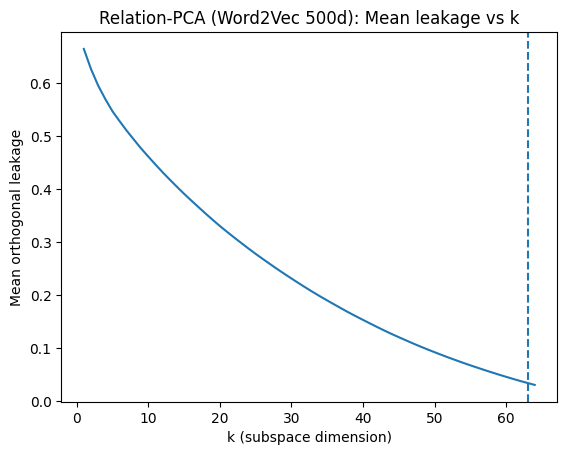

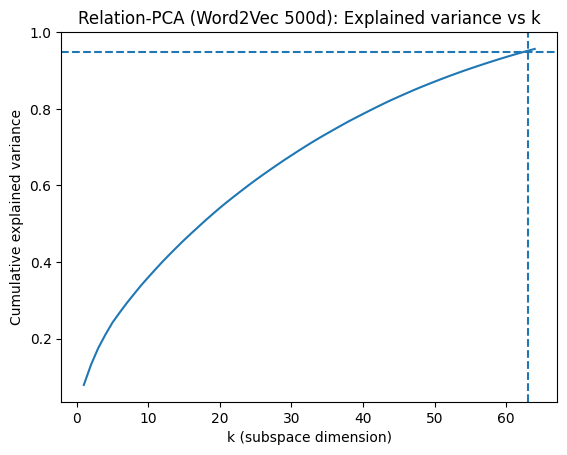

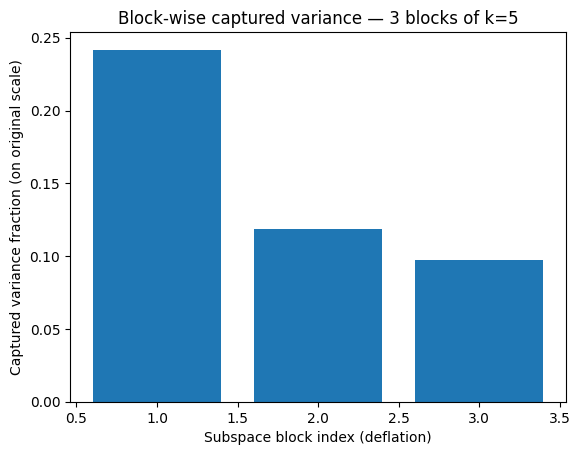

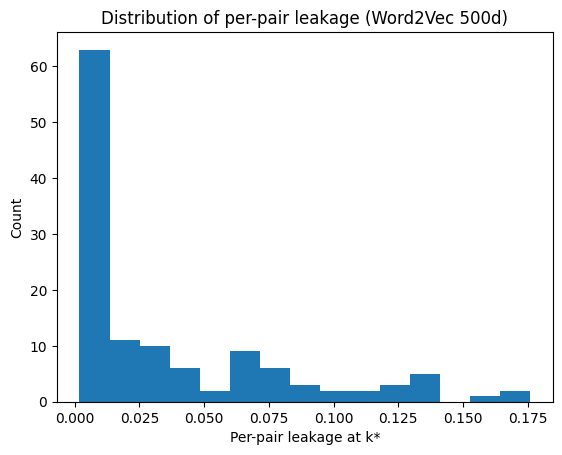

In [ ]:
# # ============================ Charts ============================

# # 1) Mean leakage vs k (nested)
# plt.figure()
# plt.plot(res["k_grid"], res["mean_leakage"])
# plt.axvline(k_star, linestyle="--")
# plt.xlabel("k (subspace dimension)")
# plt.ylabel("Mean orthogonal leakage")
# plt.title("Relation-PCA (Word2Vec 500d): Mean leakage vs k")
# plt.show()

# # 2) Cumulative explained variance vs k (nested)
# plt.figure()
# plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
# plt.axhline(VAR_TARGET, linestyle="--")
# plt.axvline(k_star, linestyle="--")
# plt.xlabel("k (subspace dimension)")
# plt.ylabel("Cumulative explained variance")
# plt.title("Relation-PCA (Word2Vec 500d): Explained variance vs k")
# plt.show()

# # 3) Block-wise captured variance (deflation)
# plt.figure()
# plt.bar([bi["block_index"] for bi in block_info],
#         [bi["captured_variance_fraction"] for bi in block_info])
# plt.xlabel("Subspace block index (deflation)")
# plt.ylabel("Captured variance fraction (on original scale)")
# plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
# plt.show()

# # 4) Histogram of per-pair leakage at k*
# plt.figure()
# plt.hist(pair_leak, bins=15)
# plt.xlabel("Per-pair leakage at k*")
# plt.ylabel("Count")
# plt.title("Distribution of per-pair leakage (Word2Vec 500d)")
# plt.show()

### **GloVE**

In [ ]:
import os, re, zipfile, subprocess, sys
from typing import List, Tuple, Optional, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========================= DOWNLOAD / CHOOSE FILE =========================
# Choose which GloVe to use. 6B is small & easy; 840B is much larger.
USE_840B = False  # set True to use the big 840B 300d file (needs ~5.3 GB unzipped)

if USE_840B:
    GLOVE_ZIP_URL = "https://nlp.stanford.edu/data/glove.840B.300d.zip"
    GLOVE_ZIP     = "/content/glove.840B.300d.zip"
    GLOVE_TXT     = "/content/glove.840B.300d.txt"
else:
    GLOVE_ZIP_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
    GLOVE_ZIP     = "/content/glove.6B.zip"
    # pick the 300d file from the 6B bundle
    GLOVE_TXT     = "/content/glove.6B.300d.txt"

def _download(url: str, dest: str):
    if not os.path.exists(dest):
        print(f"Downloading: {url}")
        # use curl (quiet) to avoid wget SSL quirks on some Colab setups
        subprocess.run(["curl", "-L", "-o", dest, url], check=True)
    else:
        print(f"Found existing: {dest}")

def _unzip(zip_path: str, target_dir: str = "/content/"):
    print(f"Extracting: {zip_path}")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(target_dir)

if not os.path.exists(GLOVE_TXT):
    _download(GLOVE_ZIP_URL, GLOVE_ZIP)
    if GLOVE_ZIP.endswith(".zip"):
        _unzip(GLOVE_ZIP)
    else:
        print("Non-zip detected; ensure your path is correct.")

print(f"Using GloVe file: {GLOVE_TXT}")
assert os.path.exists(GLOVE_TXT), "GloVe .txt file not found after download/unzip."

K_MAX       = 64        # nested subspaces: evaluate k = 1..K_MAX
VAR_TARGET  = 0.95      # choose k* as the smallest k reaching this explained variance
NORMALIZE   = True      # L2-normalize rows of U, V before PCA

# Deflation: learn multiple k-flats sequentially on residuals
NUM_SUBSPACES = 3       # number of blocks
K_BLOCK       = 5       # dimension per block


Downloading: https://nlp.stanford.edu/data/glove.6B.zip
Extracting: /content/glove.6B.zip
Using GloVe file: /content/glove.6B.300d.txt


In [ ]:

# ====================== GloVe loader & embed ======================

def load_glove_txt(path: str, max_vocab: Optional[int] = None) -> Dict[str, np.ndarray]:
    """
    Minimal GloVe text loader: 'token val1 ... valD' per line (no header).
    Returns a dict token -> vector (np.float32). Infers dim from the first line.
    """
    emb: Dict[str, np.ndarray] = {}
    dim: Optional[int] = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if max_vocab is not None and len(emb) >= max_vocab:
                break
            parts = line.strip().split(" ")
            if len(parts) < 2:
                continue
            token, vals = parts[0], parts[1:]
            if dim is None:
                dim = len(vals)
            try:
                vec = np.asarray(vals[:dim], dtype=np.float32)
                if vec.size == dim:
                    emb[token] = vec
            except Exception:
                continue
    if not emb:
        raise RuntimeError("Failed to load any vectors; check path and file format.")
    return emb

def tokenize(text: str) -> List[str]:
    # simple a..z tokenizer; lowercase; splits multiword names to average
    return [t for t in re.split(r"[^A-Za-z]+", text.lower()) if t]

def lookup_glove(emb: Dict[str, np.ndarray], token: str) -> Optional[np.ndarray]:
    # try exact, lowercase, underscores; else None
    for cand in (token, token.lower(), token.replace(" ", "_"), token.lower().replace(" ", "_")):
        if cand in emb: return emb[cand]
    return None

def embed_phrase(emb: Dict[str, np.ndarray], phrase: str) -> Optional[np.ndarray]:
    toks = tokenize(phrase)
    if not toks: toks = [phrase]
    vecs = [emb[t] for t in toks if t in emb]
    if vecs:
        return np.mean(vecs, axis=0)
    # last resort: try the whole phrase with underscore
    v = lookup_glove(emb, phrase)
    return v

def embed_pairs_glove(emb: Dict[str, np.ndarray], pairs: List[Tuple[str,str]]):
    U_rows, V_rows, kept_pairs = [], [], []
    for u, v in pairs:
        u_vec = embed_phrase(emb, u)
        v_vec = embed_phrase(emb, v)
        if u_vec is None or v_vec is None:
            continue
        U_rows.append(u_vec); V_rows.append(v_vec); kept_pairs.append((u, v))
    if not U_rows:
        raise RuntimeError("No pairs could be embedded; check your vocabulary and pairs.")
    U = np.vstack(U_rows).astype(np.float32)
    V = np.vstack(V_rows).astype(np.float32)
    return U, V, kept_pairs

In [ ]:
# ====================== Relation-PCA (core) ======================

def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
    """
    Relation-PCA on centered Δ = V - U using NumPy (eigh on covariance).
    Returns eigensystem and per-k metrics.
    """
    assert U.shape == V.shape, "U and V must have same shape."
    n, d = U.shape
    Delta = V - U
    Delta = Delta - np.mean(Delta, axis=0)

    C = np.matmul(Delta.T, Delta) / float(n)     # d x d
    eigvals, eigvecs = np.linalg.eigh(C)         # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    total_energy = np.sum(Delta**2, axis=1)
    k_max = min(int(k_max), d)
    k_grid = list(range(1, k_max + 1))
    explained = np.cumsum(eigvals) / np.sum(eigvals)

    mean_leak, median_leak = [], []
    for k in k_grid:
        P = eigvecs[:, :k]
        captured = np.sum((Delta @ P)**2, axis=1)
        leakage  = total_energy - captured
        mean_leak.append(float(leakage.mean()))
        median_leak.append(float(np.median(leakage)))

    return {
        "eigvecs": eigvecs, "eigvals": eigvals,
        "Delta_centered": Delta, "total_energy": total_energy,
        "k_grid": k_grid,
        "mean_leakage": mean_leak, "median_leakage": median_leak,
        "explained_variance_ratio": [float(x) for x in explained[:k_max]],
        "n_pairs": n, "d": d
    }

def choose_k_star(explained_ratio, target=0.95):
    for i, v in enumerate(explained_ratio, start=1):
        if v >= target:
            return i
    return len(explained_ratio)

def per_pair_leakage_at_k(res: dict, k: int):
    Delta = res["Delta_centered"]
    P = res["eigvecs"][:, :k]
    captured = np.sum((Delta @ P)**2, axis=1)
    leakage  = res["total_energy"] - captured
    return leakage, captured

# -------- Multi-subspace via deflation (sequential k-flats) --------

def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
    n, d = Delta_centered.shape
    resid = Delta_centered.copy()
    total_var = float((resid**2).sum()) / n

    blocks, block_info = [], []
    for b in range(num_subspaces):
        Cb = (resid.T @ resid) / n
        w, V = np.linalg.eigh(Cb)
        order = np.argsort(w)[::-1]
        w, V = w[order], V[:, order]
        P_b = V[:, :k_block]
        captured_vec = np.sum((resid @ P_b)**2, axis=1)
        leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
        blocks.append(P_b)
        resid = resid - (resid @ P_b) @ P_b.T
        block_info.append({
            "block_index": b+1,
            "k_block": int(k_block),
            "captured_variance_fraction": float(captured_vec.mean() / total_var),
            "mean_leakage_on_residuals": float(leakage_vec.mean()),
            "median_leakage_on_residuals": float(np.median(leakage_vec)),
        })

    P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
    Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
    return Q[:, :P_total.shape[1]], block_info


In [ ]:
# ============================ RUN ============================

PAIRS = [
    ("paris", "france"), ("rome", "italy"), ("madrid", "spain"), ("berlin", "germany"),
    ("lisbon", "portugal"), ("london", "united kingdom"), ("dublin", "ireland"), ("athens", "greece"),
    ("vienna", "austria"), ("brussels", "belgium"), ("amsterdam", "netherlands"), ("luxembourg", "luxembourg"),
    ("bern", "switzerland"), ("oslo", "norway"), ("stockholm", "sweden"), ("copenhagen", "denmark"),
    ("helsinki", "finland"), ("reykjavik", "iceland"), ("tallinn", "estonia"), ("riga", "latvia"),
    ("vilnius", "lithuania"), ("warsaw", "poland"), ("prague", "czechia"), ("bratislava", "slovakia"),
    ("budapest", "hungary"), ("ljubljana", "slovenia"), ("zagreb", "croatia"), ("belgrade", "serbia"),
    ("sarajevo", "bosnia and herzegovina"), ("tirana", "albania"), ("podgorica", "montenegro"), ("skopje", "north macedonia"),
    ("pristina", "kosovo"), ("sofia", "bulgaria"), ("bucharest", "romania"), ("chisinau", "moldova"),
    ("kyiv", "ukraine"), ("minsk", "belarus"), ("moscow", "russia"), ("vatican city", "vatican city"),
    ("valletta", "malta"), ("nicosia", "cyprus"), ("monaco", "monaco"), ("andorra la vella", "andorra"),
    ("san marino", "san marino"), ("ankara", "turkey"), ("tehran", "iran"), ("baghdad", "iraq"),
    ("damascus", "syria"), ("amman", "jordan"), ("beirut", "lebanon"), ("jerusalem", "israel"),
    ("riyadh", "saudi arabia"), ("doha", "qatar"), ("abu dhabi", "united arab emirates"), ("kuwait city", "kuwait"),
    ("manama", "bahrain"), ("muscat", "oman"), ("sanaa", "yemen"), ("kabul", "afghanistan"),
    ("islamabad", "pakistan"), ("new delhi", "india"), ("kathmandu", "nepal"), ("thimphu", "bhutan"),
    ("dhaka", "bangladesh"), ("colombo", "sri lanka"), ("male", "maldives"), ("bangkok", "thailand"),
    ("hanoi", "vietnam"), ("phnom penh", "cambodia"), ("vientiane", "laos"), ("yangon", "myanmar"),
    ("kuala lumpur", "malaysia"), ("singapore", "singapore"), ("jakarta", "indonesia"), ("manila", "philippines"),
    ("dili", "east timor"), ("bandar seri begawan", "brunei"), ("beijing", "china"), ("ulaanbaatar", "mongolia"),
    ("pyongyang", "north korea"), ("seoul", "south korea"), ("tokyo", "japan"), ("cairo", "egypt"),
    ("tripoli", "libya"), ("tunis", "tunisia"), ("algiers", "algeria"), ("rabat", "morocco"),
    ("nouakchott", "mauritania"), ("bamako", "mali"), ("niamey", "niger"), ("ndjamena", "chad"),
    ("khartoum", "sudan"), ("addis ababa", "ethiopia"), ("djibouti", "djibouti"), ("asmara", "eritrea"),
    ("mogadishu", "somalia"), ("nairobi", "kenya"), ("kampala", "uganda"), ("kigali", "rwanda"),
    ("dodoma", "tanzania"), ("bujumbura", "burundi"), ("libreville", "gabon"), ("brazzaville", "republic of the congo"),
    ("kinshasa", "democratic republic of the congo"), ("luanda", "angola"), ("lusaka", "zambia"), ("harare", "zimbabwe"),
    ("maputo", "mozambique"), ("antananarivo", "madagascar"), ("port louis", "mauritius"), ("gaborone", "botswana"),
    ("windhoek", "namibia"), ("pretoria", "south africa"), ("maseru", "lesotho"), ("mbabane", "eswatini"),
    ("lilongwe", "malawi"), ("accra", "ghana"), ("dakar", "senegal"), ("freetown", "sierra leone"),
    ("monrovia", "liberia"), ("abidjan", "cote d'ivoire"), ("ouagadougou", "burkina faso"), ("porto-novo", "benin"),
    ("abja", "nigeria")
]

print(f"Loading GloVe from: {GLOVE_TXT}")
glove = load_glove_txt(GLOVE_TXT)
dim = len(next(iter(glove.values())))
print(f"Loaded {len(glove):,} tokens | dim={dim}")

capitals  = [u for (u, _) in PAIRS]
countries = [v for (_, v) in PAIRS]

U, V, kept = embed_pairs_glove(glove, PAIRS)
print(f"Pairs found in vocab: {len(kept)}/{len(PAIRS)}")

if NORMALIZE:
    U = U / np.maximum(np.linalg.norm(U, axis=1, keepdims=True), 1e-12)
    V = V / np.maximum(np.linalg.norm(V, axis=1, keepdims=True), 1e-12)


Loading GloVe from: /content/glove.6B.300d.txt
Loaded 400,000 tokens | dim=300
Pairs found in vocab: 123/125


In [ ]:

# ---- (A) Nested subspaces: k = 1..K_MAX ----
res = pca_on_deltas(U, V, k_max=K_MAX)
k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)
k_star_mse = int(1 + np.argmin(res["mean_leakage"]))
k_star = min(k_star_var, k_star_mse)

pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

print("\n=== Nested-subspace summary (k sweep) ===")
print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
print(f"Evaluated k = 1..{res['k_grid'][-1]}")
print(f"Chosen k* = {k_star} (min of variance-threshold and MSE-min)")
print(f"  - EVR at k*: {res['explained_variance_ratio'][k_star-1]*100:.2f}%  (target={VAR_TARGET*100:.1f}%)")
print(f"  - Mean leakage at k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# Per-pair leakage at k* (sorted)
df_pairs = pd.DataFrame({
    "capital": [u for (u, _) in kept],
    "country": [v for (_, v) in kept],
    "leakage_k*": pair_leak,
    "captured_energy_k*": pair_captured,
    "total_energy": res["total_energy"],
}).sort_values("leakage_k*", ascending=True).reset_index(drop=True)

print("\n=== Per-pair leakage at k* (sorted) ===")
print(df_pairs.to_string(index=False, max_colwidth=30))

# Combined metrics across k
df_k = pd.DataFrame({
    "k": res["k_grid"],
    "mean_leakage": res["mean_leakage"],
    "median_leakage": res["median_leakage"],
    "explained_variance_ratio": res["explained_variance_ratio"],
})
print("\n=== Leakage & explained variance across k (nested) ===")
print(df_k.to_string(index=False, max_colwidth=20))

# ---- (B) Multiple k-flats via deflation ----
Delta_c = res["Delta_centered"]
P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
df_blocks = pd.DataFrame(block_info)
print(df_blocks.to_string(index=False))

captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
overall_evr = captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])
print(f"\nCombined blocks (total k = {P_total.shape[1]}): "
      f"Mean leakage = {leakage_blocks.mean():.6f}, EVR = {overall_evr*100:.2f}%")



=== Nested-subspace summary (k sweep) ===
Pairs used: 123 | Embedding dim: 300
Evaluated k = 1..64
Chosen k* = 64 (min of variance-threshold and MSE-min)
  - EVR at k*: 90.18%  (target=95.0%)
  - Mean leakage at k*: 0.048995 | Median: 0.053199

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
         luxembourg                     luxembourg    0.003517            0.282167      0.285684
       vatican city                   vatican city    0.003517            0.282167      0.285684
             monaco                         monaco    0.003517            0.282167      0.285684
          singapore                      singapore    0.003517            0.282167      0.285684
           djibouti                       djibouti    0.003518            0.282167      0.285684
         san marino                     san marino    0.003518            0.282167      0.285684
               male                

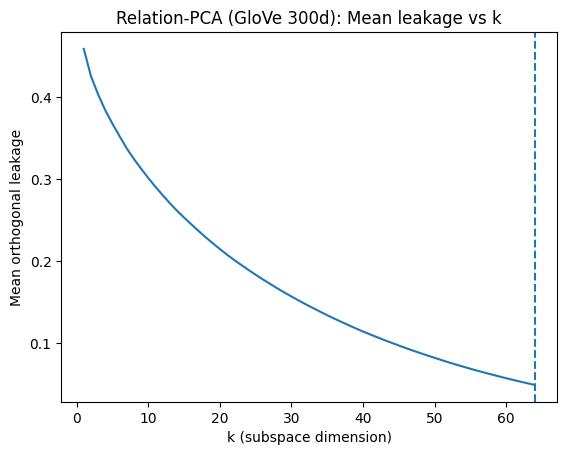

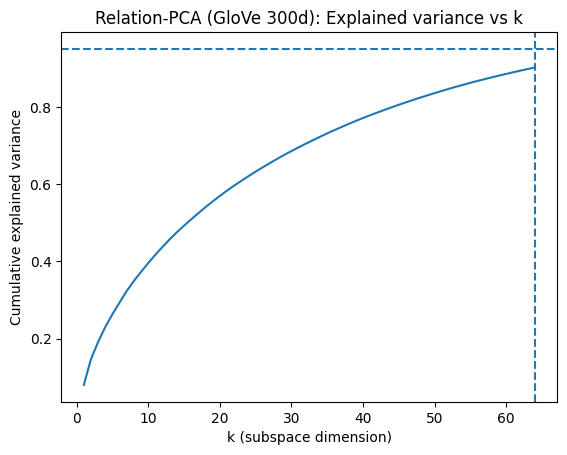

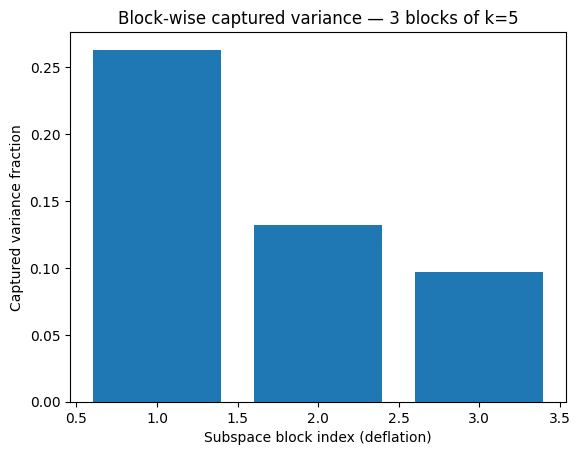

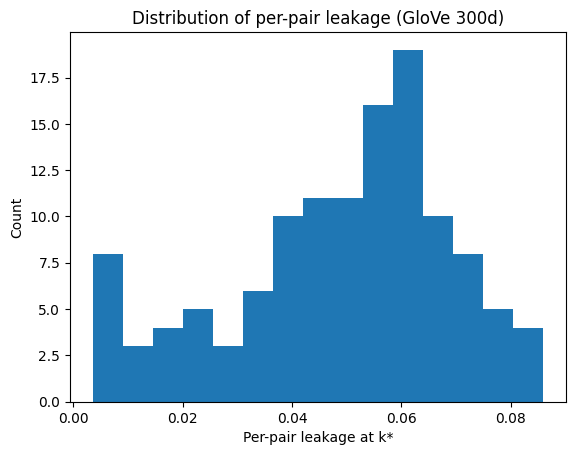

In [ ]:
# ============================ Charts ============================

# 1) Mean leakage vs k (nested)
plt.figure()
plt.plot(res["k_grid"], res["mean_leakage"])
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Mean orthogonal leakage")
plt.title(f"Relation-PCA (GloVe {dim}d): Mean leakage vs k")
plt.show()

# 2) Cumulative explained variance vs k (nested)
plt.figure()
plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
plt.axhline(VAR_TARGET, linestyle="--")
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Cumulative explained variance")
plt.title(f"Relation-PCA (GloVe {dim}d): Explained variance vs k")
plt.show()

# 3) Block-wise captured variance (deflation)
plt.figure()
plt.bar([bi["block_index"] for bi in block_info],
        [bi["captured_variance_fraction"] for bi in block_info])
plt.xlabel("Subspace block index (deflation)")
plt.ylabel("Captured variance fraction")
plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
plt.show()

# 4) Histogram of per-pair leakage at k*
plt.figure()
plt.hist(pair_leak, bins=15)
plt.xlabel("Per-pair leakage at k*")
plt.ylabel("Count")
plt.title(f"Distribution of per-pair leakage (GloVe {dim}d)")
plt.show()

### **BERT**

In [ ]:
import re, math
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
MODEL_ID = "bert-base-uncased"   # BERT base (768-d) :contentReference[oaicite:2]{index=2}
POOLING  = "mean"                # "mean" (recommended) or "cls"  :contentReference[oaicite:3]{index=3}
BATCH_SIZE = 32
MAX_LENGTH = 32                  # truncation length; fine for short names
L2_NORMALIZE = True
K_MAX = 64                       # evaluate k = 1..K_MAX
VAR_TARGET = 0.95                # choose k* as smallest k reaching this EVR
# Multi-subspace via deflation:
NUM_SUBSPACES = 3
K_BLOCK = 5

In [ ]:
# ========================= BERT embedder =========================
class BertEmbedder:
    """
    Mean pooling (default) over last_hidden_state, masked by attention_mask.  :contentReference[oaicite:4]{index=4}
    Switch POOLING='cls' to use the [CLS] token embedding.
    """
    def __init__(self, model_id=MODEL_ID, pooling=POOLING, device=None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModel.from_pretrained(model_id)
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device).eval()
        self.pooling = pooling
        self.hidden_size = int(self.model.config.hidden_size)

    @torch.no_grad()
    def encode(self, texts: List[str], batch_size=BATCH_SIZE, max_length=MAX_LENGTH) -> np.ndarray:
        out_list = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = self.tokenizer(
                batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
            ).to(self.device)
            outputs = self.model(**enc)
            last_hidden = outputs.last_hidden_state  # [B, T, H]
            if self.pooling == "cls":
                pooled = last_hidden[:, 0]           # [CLS]
            else:
                # mean pooling with attention mask
                mask = enc["attention_mask"].unsqueeze(-1)  # [B,T,1]
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                pooled = summed / counts
            out_list.append(pooled.cpu().numpy())
        return np.vstack(out_list).astype(np.float32)

In [ ]:
# ========================= Relation-PCA core =========================
def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
    """
    Relation-PCA on centered Δ = V - U (orthogonal MSE minimization).
    Returns eigensystem + per-k metrics.
    """
    assert U.shape == V.shape
    n, d = U.shape
    Delta = (V.astype(np.float64) - U.astype(np.float64))
    Delta -= Delta.mean(axis=0, keepdims=True)

    C = (Delta.T @ Delta) / float(n)                 # d x d
    eigvals, eigvecs = np.linalg.eigh(C)             # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    total_energy = np.sum(Delta**2, axis=1)          # per-pair total
    k_max = min(int(k_max), d)
    k_grid = list(range(1, k_max + 1))
    explained = np.cumsum(eigvals) / np.sum(eigvals)

    mean_leak, median_leak = [], []
    for k in k_grid:
        P = eigvecs[:, :k]
        captured = np.sum((Delta @ P)**2, axis=1)
        leakage  = total_energy - captured
        mean_leak.append(float(leakage.mean()))
        median_leak.append(float(np.median(leakage)))

    return {
        "eigvecs": eigvecs, "eigvals": eigvals,
        "Delta_centered": Delta, "total_energy": total_energy,
        "k_grid": k_grid,
        "mean_leakage": mean_leak, "median_leakage": median_leak,
        "explained_variance_ratio": [float(x) for x in explained[:k_max]],
        "n_pairs": n, "d": d
    }

def choose_k_star(explained_ratio, target=0.95):
    for i, v in enumerate(explained_ratio, start=1):
        if v >= target:
            return i
    return len(explained_ratio)

def per_pair_leakage_at_k(res: dict, k: int):
    Delta = res["Delta_centered"]
    P = res["eigvecs"][:, :k]
    captured = np.sum((Delta @ P)**2, axis=1)
    leakage  = res["total_energy"] - captured
    return leakage, captured

# Multiple k-flats via deflation (sequential, optimal on residuals)
def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
    n, d = Delta_centered.shape
    resid = Delta_centered.copy()
    total_var = float((resid**2).sum()) / n
    blocks, block_info = [], []
    for b in range(num_subspaces):
        Cb = (resid.T @ resid) / n
        w, V = np.linalg.eigh(Cb)
        order = np.argsort(w)[::-1]
        P_b = V[:, order][:, :k_block]
        captured_vec = np.sum((resid @ P_b)**2, axis=1)
        leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
        blocks.append(P_b)
        resid = resid - (resid @ P_b) @ P_b.T
        block_info.append({
            "block_index": b+1,
            "k_block": int(k_block),
            "captured_variance_fraction": float(captured_vec.mean() / total_var),
            "mean_leakage_on_residuals": float(leakage_vec.mean()),
            "median_leakage_on_residuals": float(np.median(leakage_vec)),
        })
    P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
    Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
    return Q[:, :P_total.shape[1]], block_info

In [ ]:
PAIRS = [
    ("paris", "france"), ("rome", "italy"), ("madrid", "spain"), ("berlin", "germany"),
    ("lisbon", "portugal"), ("london", "united kingdom"), ("dublin", "ireland"), ("athens", "greece"),
    ("vienna", "austria"), ("brussels", "belgium"), ("amsterdam", "netherlands"), ("luxembourg", "luxembourg"),
    ("bern", "switzerland"), ("oslo", "norway"), ("stockholm", "sweden"), ("copenhagen", "denmark"),
    ("helsinki", "finland"), ("reykjavik", "iceland"), ("tallinn", "estonia"), ("riga", "latvia"),
    ("vilnius", "lithuania"), ("warsaw", "poland"), ("prague", "czechia"), ("bratislava", "slovakia"),
    ("budapest", "hungary"), ("ljubljana", "slovenia"), ("zagreb", "croatia"), ("belgrade", "serbia"),
    ("sarajevo", "bosnia and herzegovina"), ("tirana", "albania"), ("podgorica", "montenegro"), ("skopje", "north macedonia"),
    ("pristina", "kosovo"), ("sofia", "bulgaria"), ("bucharest", "romania"), ("chisinau", "moldova"),
    ("kyiv", "ukraine"), ("minsk", "belarus"), ("moscow", "russia"), ("vatican city", "vatican city"),
    ("valletta", "malta"), ("nicosia", "cyprus"), ("monaco", "monaco"), ("andorra la vella", "andorra"),
    ("san marino", "san marino"), ("ankara", "turkey"), ("tehran", "iran"), ("baghdad", "iraq"),
    ("damascus", "syria"), ("amman", "jordan"), ("beirut", "lebanon"), ("jerusalem", "israel"),
    ("riyadh", "saudi arabia"), ("doha", "qatar"), ("abu dhabi", "united arab emirates"), ("kuwait city", "kuwait"),
    ("manama", "bahrain"), ("muscat", "oman"), ("sanaa", "yemen"), ("kabul", "afghanistan"),
    ("islamabad", "pakistan"), ("new delhi", "india"), ("kathmandu", "nepal"), ("thimphu", "bhutan"),
    ("dhaka", "bangladesh"), ("colombo", "sri lanka"), ("male", "maldives"), ("bangkok", "thailand"),
    ("hanoi", "vietnam"), ("phnom penh", "cambodia"), ("vientiane", "laos"), ("yangon", "myanmar"),
    ("kuala lumpur", "malaysia"), ("singapore", "singapore"), ("jakarta", "indonesia"), ("manila", "philippines"),
    ("dili", "east timor"), ("bandar seri begawan", "brunei"), ("beijing", "china"), ("ulaanbaatar", "mongolia"),
    ("pyongyang", "north korea"), ("seoul", "south korea"), ("tokyo", "japan"), ("cairo", "egypt"),
    ("tripoli", "libya"), ("tunis", "tunisia"), ("algiers", "algeria"), ("rabat", "morocco"),
    ("nouakchott", "mauritania"), ("bamako", "mali"), ("niamey", "niger"), ("ndjamena", "chad"),
    ("khartoum", "sudan"), ("addis ababa", "ethiopia"), ("djibouti", "djibouti"), ("asmara", "eritrea"),
    ("mogadishu", "somalia"), ("nairobi", "kenya"), ("kampala", "uganda"), ("kigali", "rwanda"),
    ("dodoma", "tanzania"), ("bujumbura", "burundi"), ("libreville", "gabon"), ("brazzaville", "republic of the congo"),
    ("kinshasa", "democratic republic of the congo"), ("luanda", "angola"), ("lusaka", "zambia"), ("harare", "zimbabwe"),
    ("maputo", "mozambique"), ("antananarivo", "madagascar"), ("port louis", "mauritius"), ("gaborone", "botswana"),
    ("windhoek", "namibia"), ("pretoria", "south africa"), ("maseru", "lesotho"), ("mbabane", "eswatini"),
    ("lilongwe", "malawi"), ("accra", "ghana"), ("dakar", "senegal"), ("freetown", "sierra leone"),
    ("monrovia", "liberia"), ("abidjan", "cote d'ivoire"), ("ouagadougou", "burkina faso"), ("porto-novo", "benin"),
    ("abja", "nigeria")
]

In [ ]:
# ========================= Run =========================
embedder = BertEmbedder(MODEL_ID, pooling=POOLING)
print(f"Model: {MODEL_ID} | hidden_size (dimension): {embedder.hidden_size}")

capitals  = [u for (u, _) in PAIRS]
countries = [v for (_, v) in PAIRS]

U = embedder.encode(capitals)
V = embedder.encode(countries)

if L2_NORMALIZE:
    U = U / np.maximum(np.linalg.norm(U, axis=1, keepdims=True), 1e-12)
    V = V / np.maximum(np.linalg.norm(V, axis=1, keepdims=True), 1e-12)

# (A) Nested subspaces k = 1..K_MAX
res = pca_on_deltas(U, V, k_max=K_MAX)

k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)
k_star_mse = int(1 + np.argmin(res["mean_leakage"]))
k_star = min(k_star_var, k_star_mse)

pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

print("\n=== Nested-subspace summary (k sweep) ===")
print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
print(f"Evaluated k = 1..{res['k_grid'][-1]}")
print(f"Chosen k* = {k_star}  (EVR target={VAR_TARGET*100:.1f}%,  EVR@k*={res['explained_variance_ratio'][k_star-1]*100:.2f}%)")
print(f"Mean leakage@k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# Per-pair leakage at k* (sorted)
df_pairs = pd.DataFrame({
    "capital": capitals,
    "country": countries,
    "leakage_k*": pair_leak,
    "captured_energy_k*": pair_captured,
    "total_energy": res["total_energy"],
}).sort_values("leakage_k*", ascending=True).reset_index(drop=True)
print("\n=== Per-pair leakage at k* (sorted) ===")
print(df_pairs.to_string(index=False, max_colwidth=30))

# Combined metrics across k
df_k = pd.DataFrame({
    "k": res["k_grid"],
    "mean_leakage": res["mean_leakage"],
    "median_leakage": res["median_leakage"],
    "explained_variance_ratio": res["explained_variance_ratio"],
})
print("\n=== Leakage & explained variance across k (nested) ===")
print(df_k.to_string(index=False, max_colwidth=20))

# (B) Multiple k-flats via deflation
Delta_c = res["Delta_centered"]
P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
df_blocks = pd.DataFrame(block_info)
print(df_blocks.to_string(index=False))

captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
overall_evr = captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])
print(f"\nCombined blocks (total k = {P_total.shape[1]}): Mean leakage = {leakage_blocks.mean():.6f}, EVR = {overall_evr*100:.2f}%")


Model: bert-base-uncased | hidden_size (dimension): 768

=== Nested-subspace summary (k sweep) ===
Pairs used: 125 | Embedding dim: 768
Evaluated k = 1..64
Chosen k* = 64  (EVR target=95.0%,  EVR@k*=90.99%)
Mean leakage@k*: 0.036328 | Median: 0.035638

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
             maseru                        lesotho    0.002536            0.879635      0.882171
         porto-novo                          benin    0.005655            0.778534      0.784189
               dili                     east timor    0.005957            0.640755      0.646713
bandar seri begawan                         brunei    0.006093            0.827953      0.834047
           djibouti                       djibouti    0.006522            0.070162      0.076685
         luxembourg                     luxembourg    0.006522            0.070162      0.076685
             monaco         

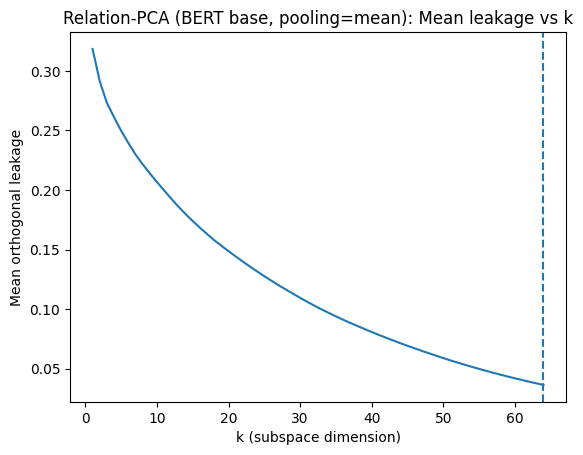

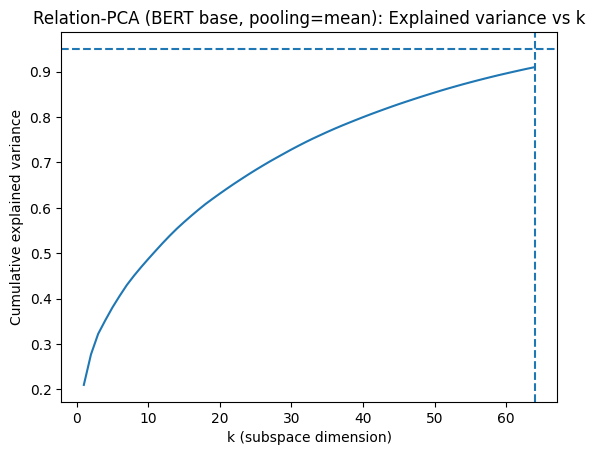

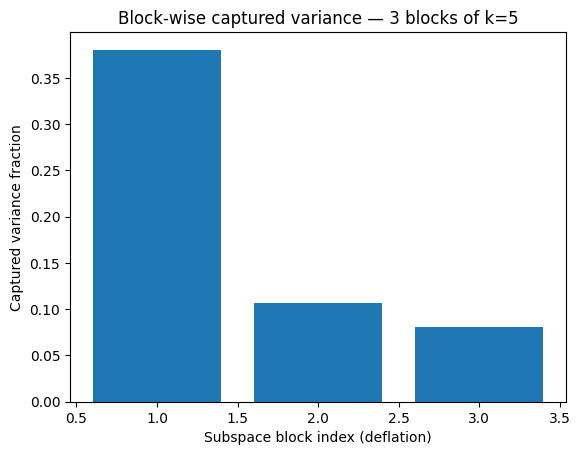

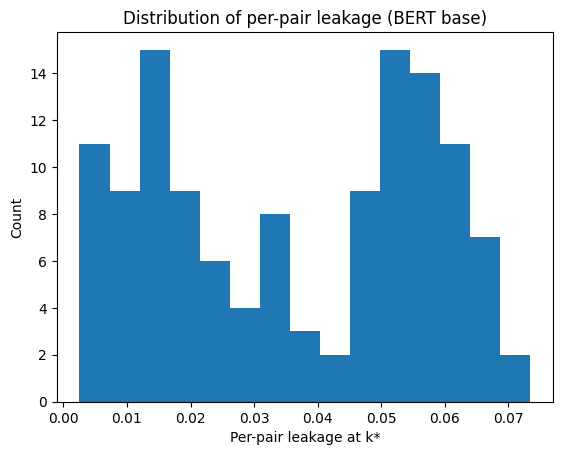

In [ ]:
# ========================= Charts =========================
plt.figure()
plt.plot(res["k_grid"], res["mean_leakage"])
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Mean orthogonal leakage")
plt.title(f"Relation-PCA (BERT base, pooling={POOLING}): Mean leakage vs k")
plt.show()

plt.figure()
plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
plt.axhline(VAR_TARGET, linestyle="--")
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Cumulative explained variance")
plt.title(f"Relation-PCA (BERT base, pooling={POOLING}): Explained variance vs k")
plt.show()

plt.figure()
plt.bar([bi["block_index"] for bi in block_info],
        [bi["captured_variance_fraction"] for bi in block_info])
plt.xlabel("Subspace block index (deflation)")
plt.ylabel("Captured variance fraction")
plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
plt.show()

plt.figure()
plt.hist(pair_leak, bins=15)
plt.xlabel("Per-pair leakage at k*")
plt.ylabel("Count")
plt.title("Distribution of per-pair leakage (BERT base)")
plt.show()

### **RobertA**

In [ ]:
import re
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
# ========================= Config =========================
MODEL_ID = "roberta-base"        # 12-layer, 768-hidden RoBERTa base
POOLING  = "mean"                # "mean" (recommended) or "cls"
BATCH_SIZE = 32
MAX_LENGTH = 32                  # truncation length; fine for short names
L2_NORMALIZE = True
K_MAX = 64                       # evaluate k = 1..K_MAX
VAR_TARGET = 0.95                # choose k* as smallest k reaching this EVR
# Multi-subspace via deflation:
NUM_SUBSPACES = 3
K_BLOCK = 5

In [ ]:
# ========================= RoBERTa embedder =========================
class RobertaEmbedder:
    """
    Mean pooling (default) over last_hidden_state, masked by attention_mask.
    Switch POOLING='cls' to use the [CLS]-equivalent (RoBERTa's first token).
    """
    def __init__(self, model_id=MODEL_ID, pooling=POOLING, device=None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModel.from_pretrained(model_id)
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device).eval()
        self.pooling = pooling
        self.hidden_size = int(self.model.config.hidden_size)

    @torch.no_grad()
    def encode(self, texts: List[str], batch_size=BATCH_SIZE, max_length=MAX_LENGTH) -> np.ndarray:
        out = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = self.tokenizer(
                batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
            ).to(self.device)
            outputs = self.model(**enc)
            last_hidden = outputs.last_hidden_state  # [B, T, H]
            if self.pooling == "cls":
                pooled = last_hidden[:, 0]           # first token embedding
            else:
                mask = enc["attention_mask"].unsqueeze(-1)  # [B,T,1]
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                pooled = summed / counts
            out.append(pooled.cpu().numpy())
        return np.vstack(out).astype(np.float32)

In [ ]:
# ========================= Relation-PCA core =========================
def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
    """
    Relation-PCA on centered Δ = V - U (orthogonal MSE minimization).
    Returns eigensystem + per-k metrics.
    """
    assert U.shape == V.shape
    n, d = U.shape
    Delta = (V.astype(np.float64) - U.astype(np.float64))
    Delta -= Delta.mean(axis=0, keepdims=True)

    C = (Delta.T @ Delta) / float(n)                 # d x d
    eigvals, eigvecs = np.linalg.eigh(C)             # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    total_energy = np.sum(Delta**2, axis=1)          # per-pair total
    k_max = min(int(k_max), d)
    k_grid = list(range(1, k_max + 1))
    explained = np.cumsum(eigvals) / np.sum(eigvals)

    mean_leak, median_leak = [], []
    for k in k_grid:
        P = eigvecs[:, :k]
        captured = np.sum((Delta @ P)**2, axis=1)
        leakage  = total_energy - captured
        mean_leak.append(float(leakage.mean()))
        median_leak.append(float(np.median(leakage)))

    return {
        "eigvecs": eigvecs, "eigvals": eigvals,
        "Delta_centered": Delta, "total_energy": total_energy,
        "k_grid": k_grid,
        "mean_leakage": mean_leak, "median_leakage": median_leak,
        "explained_variance_ratio": [float(x) for x in explained[:k_max]],
        "n_pairs": n, "d": d
    }

def choose_k_star(explained_ratio, target=0.95):
    for i, v in enumerate(explained_ratio, start=1):
        if v >= target:
            return i
    return len(explained_ratio)

def per_pair_leakage_at_k(res: dict, k: int):
    Delta = res["Delta_centered"]
    P = res["eigvecs"][:, :k]
    captured = np.sum((Delta @ P)**2, axis=1)
    leakage  = res["total_energy"] - captured
    return leakage, captured

# Multiple k-flats via deflation (sequential, optimal on residuals)
def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
    n, d = Delta_centered.shape
    resid = Delta_centered.copy()
    total_var = float((resid**2).sum()) / n
    blocks, block_info = [], []
    for b in range(num_subspaces):
        Cb = (resid.T @ resid) / n
        w, V = np.linalg.eigh(Cb)
        order = np.argsort(w)[::-1]
        P_b = V[:, order][:, :k_block]
        captured_vec = np.sum((resid @ P_b)**2, axis=1)
        leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
        blocks.append(P_b)
        resid = resid - (resid @ P_b) @ P_b.T
        block_info.append({
            "block_index": b+1,
            "k_block": int(k_block),
            "captured_variance_fraction": float(captured_vec.mean() / total_var),
            "mean_leakage_on_residuals": float(leakage_vec.mean()),
            "median_leakage_on_residuals": float(np.median(leakage_vec)),
        })
    P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
    Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
    return Q[:, :P_total.shape[1]], block_info

In [ ]:
# ========================= Run =========================
embedder = RobertaEmbedder(MODEL_ID, pooling=POOLING)
print(f"Model: {MODEL_ID} | hidden_size (dimension): {embedder.hidden_size}")

capitals  = [u for (u, _) in PAIRS]
countries = [v for (_, v) in PAIRS]

U = embedder.encode(capitals)
V = embedder.encode(countries)

if L2_NORMALIZE:
    U = U / np.maximum(np.linalg.norm(U, axis=1, keepdims=True), 1e-12)
    V = V / np.maximum(np.linalg.norm(V, axis=1, keepdims=True), 1e-12)

# (A) Nested subspaces k = 1..K_MAX
res = pca_on_deltas(U, V, k_max=K_MAX)

k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)
k_star_mse = int(1 + np.argmin(res["mean_leakage"]))
k_star = min(k_star_var, k_star_mse)

pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

print("\n=== Nested-subspace summary (k sweep) ===")
print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
print(f"Evaluated k = 1..{res['k_grid'][-1]}")
print(f"Chosen k* = {k_star}  (EVR target={VAR_TARGET*100:.1f}%,  EVR@k*={res['explained_variance_ratio'][k_star-1]*100:.2f}%)")
print(f"Mean leakage@k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# Per-pair leakage at k* (sorted)
df_pairs = pd.DataFrame({
    "capital": capitals,
    "country": countries,
    "leakage_k*": pair_leak,
    "captured_energy_k*": pair_captured,
    "total_energy": res["total_energy"],
}).sort_values("leakage_k*", ascending=True).reset_index(drop=True)
print("\n=== Per-pair leakage at k* (sorted) ===")
print(df_pairs.to_string(index=False, max_colwidth=30))

# Combined metrics across k
df_k = pd.DataFrame({
    "k": res["k_grid"],
    "mean_leakage": res["mean_leakage"],
    "median_leakage": res["median_leakage"],
    "explained_variance_ratio": res["explained_variance_ratio"],
})
print("\n=== Leakage & explained variance across k (nested) ===")
print(df_k.to_string(index=False, max_colwidth=20))

# (B) Multiple k-flats via deflation
Delta_c = res["Delta_centered"]
P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
df_blocks = pd.DataFrame(block_info)
print(df_blocks.to_string(index=False))

captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
overall_evr = captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])
print(f"\nCombined blocks (total k = {P_total.shape[1]}): Mean leakage = {leakage_blocks.mean():.6f}, EVR = {overall_evr*100:.2f}%")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: roberta-base | hidden_size (dimension): 768

=== Nested-subspace summary (k sweep) ===
Pairs used: 125 | Embedding dim: 768
Evaluated k = 1..64
Chosen k* = 64  (EVR target=95.0%,  EVR@k*=87.90%)
Mean leakage@k*: 0.009725 | Median: 0.010117

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
           djibouti                       djibouti    0.000642            0.002629      0.003272
             monaco                         monaco    0.000642            0.002629      0.003272
       vatican city                   vatican city    0.000642            0.002629      0.003272
         san marino                     san marino    0.000642            0.002629      0.003272
          singapore                      singapore    0.000642            0.002629      0.003272
         luxembourg                     luxembourg    0.000642            0.002629      0.003272
          reykjavik              

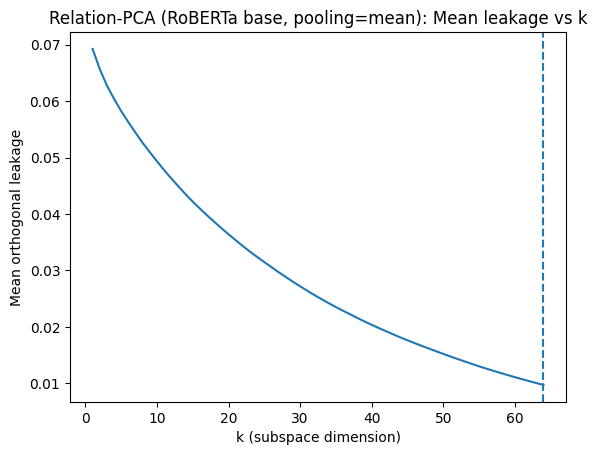

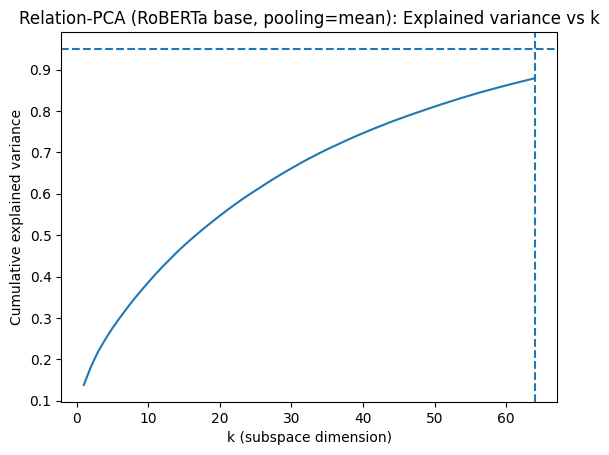

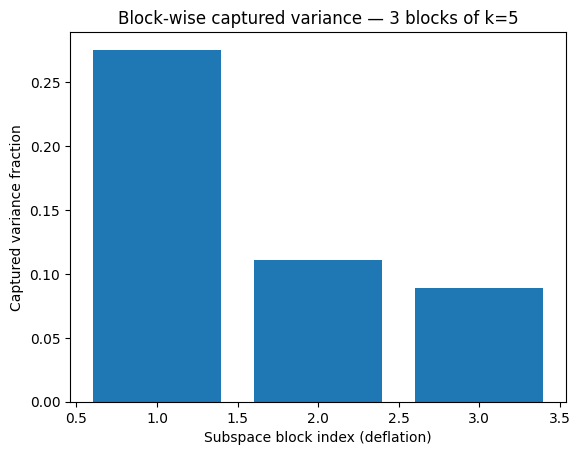

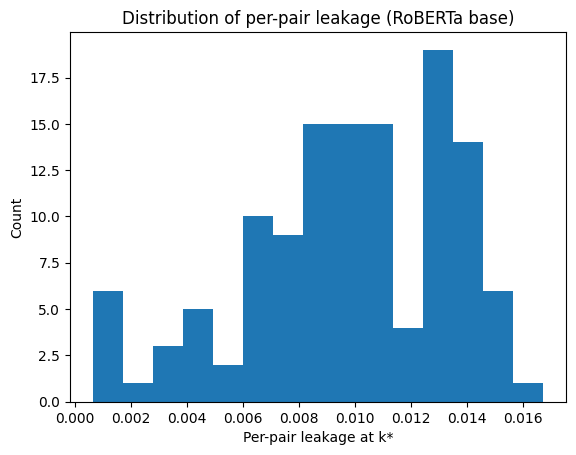

In [ ]:
# ========================= Charts =========================
plt.figure()
plt.plot(res["k_grid"], res["mean_leakage"])
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Mean orthogonal leakage")
plt.title(f"Relation-PCA (RoBERTa base, pooling={POOLING}): Mean leakage vs k")
plt.show()

plt.figure()
plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
plt.axhline(VAR_TARGET, linestyle="--")
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Cumulative explained variance")
plt.title(f"Relation-PCA (RoBERTa base, pooling={POOLING}): Explained variance vs k")
plt.show()

plt.figure()
plt.bar([bi["block_index"] for bi in block_info],
        [bi["captured_variance_fraction"] for bi in block_info])
plt.xlabel("Subspace block index (deflation)")
plt.ylabel("Captured variance fraction")
plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
plt.show()

plt.figure()
plt.hist(pair_leak, bins=15)
plt.xlabel("Per-pair leakage at k*")
plt.ylabel("Count")
plt.title("Distribution of per-pair leakage (RoBERTa base)")
plt.show()

### SBERT and LABSE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
from sentence_transformers import SentenceTransformer

In [ ]:
MODEL_ID = "sentence-transformers/paraphrase-mpnet-base-v2"  # 768-d SBERT
NORMALIZE = True         # L2-normalize embeddings (recommended for cosine geometry)
BATCH_SIZE = 64
K_MAX = 64               # evaluate nested subspaces k = 1..K_MAX
VAR_TARGET = 0.95        # choose k* as smallest k hitting this EVR
# Multi-subspace via deflation:
NUM_SUBSPACES = 3
K_BLOCK = 5

In [ ]:
# ========================= SBERT embedder =========================
model = SentenceTransformer(MODEL_ID)
print("Model:", MODEL_ID)
try:
    dim = int(model.get_sentence_embedding_dimension())
except Exception:
    # Fallback: quick probe
    dim = model.encode(["probe"]).shape[-1]
print("Embedding dimension:", dim)

def encode(texts: List[str]) -> np.ndarray:
    return model.encode(
        texts,
        batch_size=BATCH_SIZE,
        normalize_embeddings=NORMALIZE,  # keep unit-length if True
        convert_to_numpy=True,
        show_progress_bar=False
    ).astype(np.float64)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model: sentence-transformers/paraphrase-mpnet-base-v2
Embedding dimension: 768


In [ ]:
# ========================= Relation-PCA core =========================
def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
    """
    Relation-PCA on centered Δ = V - U.
    Minimizes mean squared orthogonal error and returns per-k metrics.
    """
    assert U.shape == V.shape
    n, d = U.shape
    Delta = V - U
    Delta -= Delta.mean(axis=0, keepdims=True)

    C = (Delta.T @ Delta) / float(n)        # d x d covariance
    eigvals, eigvecs = np.linalg.eigh(C)    # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    total_energy = np.sum(Delta**2, axis=1) # per-pair total
    k_max = min(int(k_max), d)
    k_grid = list(range(1, k_max+1))
    explained = np.cumsum(eigvals) / np.sum(eigvals)

    mean_leak, median_leak = [], []
    for k in k_grid:
        P = eigvecs[:, :k]
        captured = np.sum((Delta @ P)**2, axis=1)
        leakage  = total_energy - captured
        mean_leak.append(float(leakage.mean()))
        median_leak.append(float(np.median(leakage)))

    return {
        "eigvecs": eigvecs, "eigvals": eigvals,
        "Delta_centered": Delta, "total_energy": total_energy,
        "k_grid": k_grid,
        "mean_leakage": mean_leak, "median_leakage": median_leak,
        "explained_variance_ratio": [float(x) for x in explained[:k_max]],
        "n_pairs": n, "d": d
    }

def choose_k_star(explained_ratio, target=0.95) -> int:
    for i, v in enumerate(explained_ratio, start=1):
        if v >= target:
            return i
    return len(explained_ratio)

def per_pair_leakage_at_k(res: dict, k: int):
    Delta = res["Delta_centered"]
    P = res["eigvecs"][:, :k]
    captured = np.sum((Delta @ P)**2, axis=1)
    leakage  = res["total_energy"] - captured
    return leakage, captured

# Multiple subspaces via deflation
def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
    n, d = Delta_centered.shape
    resid = Delta_centered.copy()
    total_var = float((resid**2).sum()) / n
    blocks, block_info = [], []
    for b in range(num_subspaces):
        Cb = (resid.T @ resid) / n
        w, V = np.linalg.eigh(Cb)
        order = np.argsort(w)[::-1]
        P_b = V[:, order][:, :k_block]
        captured_vec = np.sum((resid @ P_b)**2, axis=1)
        leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
        blocks.append(P_b)
        resid = resid - (resid @ P_b) @ P_b.T
        block_info.append({
            "block_index": b+1,
            "k_block": int(k_block),
            "captured_variance_fraction": float(captured_vec.mean() / total_var),
            "mean_leakage_on_residuals": float(leakage_vec.mean()),
            "median_leakage_on_residuals": float(np.median(leakage_vec)),
        })
    P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
    Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
    return Q[:, :P_total.shape[1]], block_info

In [ ]:
# ========================= Run =========================
capitals  = [u for (u, _) in PAIRS]
countries = [v for (_, v) in PAIRS]

U = encode(capitals)
V = encode(countries)

# (A) Nested subspaces k = 1..K_MAX
res = pca_on_deltas(U, V, k_max=K_MAX)

k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)
k_star_mse = int(1 + np.argmin(res["mean_leakage"]))
k_star = min(k_star_var, k_star_mse)

pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

print("\n=== Nested-subspace summary (k sweep) ===")
print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
print(f"Evaluated k = 1..{res['k_grid'][-1]}")
print(f"Chosen k* = {k_star}  (EVR target={VAR_TARGET*100:.1f}%,  EVR@k*={res['explained_variance_ratio'][k_star-1]*100:.2f}%)")
print(f"Mean leakage@k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# Per-pair leakage (sorted)
df_pairs = pd.DataFrame({
    "capital": capitals,
    "country": countries,
    "leakage_k*": pair_leak,
    "captured_energy_k*": pair_captured,
    "total_energy": res["total_energy"],
}).sort_values("leakage_k*", ascending=True).reset_index(drop=True)
print("\n=== Per-pair leakage at k* (sorted) ===")
print(df_pairs.to_string(index=False, max_colwidth=30))

# k-sweep metrics table
df_k = pd.DataFrame({
    "k": res["k_grid"],
    "mean_leakage": res["mean_leakage"],
    "median_leakage": res["median_leakage"],
    "explained_variance_ratio": res["explained_variance_ratio"],
})
print("\n=== Leakage & explained variance across k (nested) ===")
print(df_k.to_string(index=False, max_colwidth=20))

# (B) Multiple subspaces via deflation
Delta_c = res["Delta_centered"]
P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
df_blocks = pd.DataFrame(block_info)
print(df_blocks.to_string(index=False))

captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
overall_evr = captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])
print(f"\nCombined blocks (total k = {P_total.shape[1]}): Mean leakage = {leakage_blocks.mean():.6f}, EVR = {overall_evr*100:.2f}%")



=== Nested-subspace summary (k sweep) ===
Pairs used: 125 | Embedding dim: 768
Evaluated k = 1..64
Chosen k* = 64  (EVR target=95.0%,  EVR@k*=91.10%)
Mean leakage@k*: 0.054300 | Median: 0.057426

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
               male                       maldives    0.010631            1.527577      1.538208
          singapore                      singapore    0.010924            0.087571      0.098494
           djibouti                       djibouti    0.010924            0.087571      0.098494
             monaco                         monaco    0.010924            0.087571      0.098494
       vatican city                   vatican city    0.010924            0.087571      0.098494
         luxembourg                     luxembourg    0.010924            0.087571      0.098494
         san marino                     san marino    0.010924            0.087571  

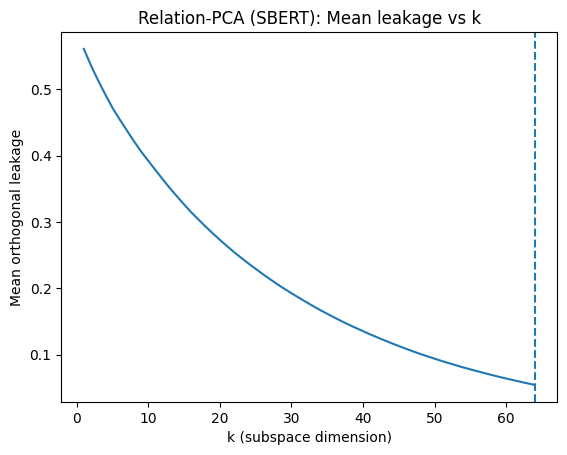

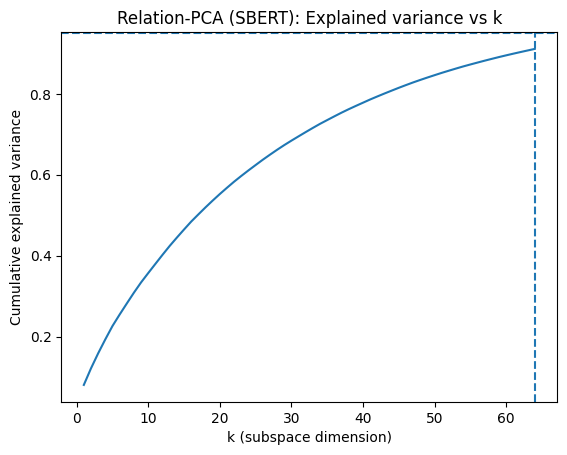

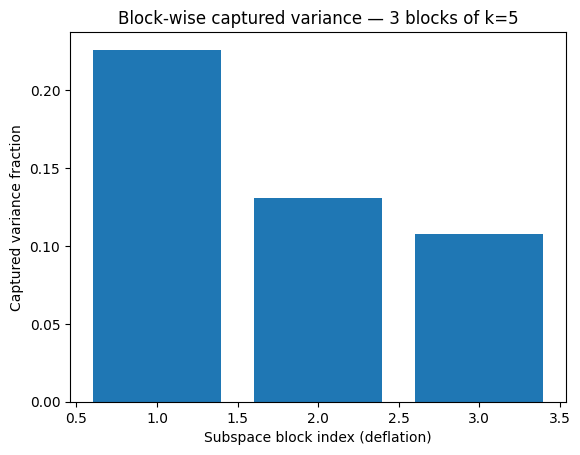

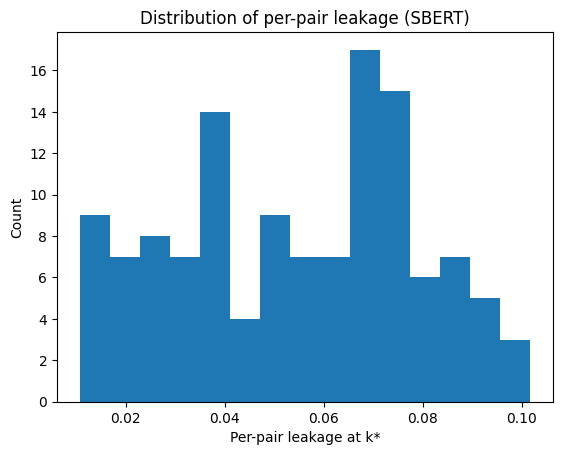

In [ ]:
# ========================= Charts =========================
plt.figure()
plt.plot(res["k_grid"], res["mean_leakage"])
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Mean orthogonal leakage")
plt.title("Relation-PCA (SBERT): Mean leakage vs k")
plt.show()

plt.figure()
plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
plt.axhline(VAR_TARGET, linestyle="--")
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Cumulative explained variance")
plt.title("Relation-PCA (SBERT): Explained variance vs k")
plt.show()

plt.figure()
plt.bar([bi["block_index"] for bi in block_info],
        [bi["captured_variance_fraction"] for bi in block_info])
plt.xlabel("Subspace block index (deflation)")
plt.ylabel("Captured variance fraction")
plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
plt.show()

plt.figure()
plt.hist(pair_leak, bins=15)
plt.xlabel("Per-pair leakage at k*")
plt.ylabel("Count")
plt.title("Distribution of per-pair leakage (SBERT)")
plt.show()

### **LABSE**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
from sentence_transformers import SentenceTransformer

In [ ]:
# ========================= Config =========================
MODEL_ID = "sentence-transformers/LaBSE"  # multilingual, 109+ langs (shared space)
NORMALIZE = True         # L2-normalize embeddings
BATCH_SIZE = 64
K_MAX = 64               # evaluate nested subspaces k = 1..K_MAX
VAR_TARGET = 0.95        # choose k* as smallest k hitting this EVR

# Optional: multiple subspaces via deflation (sequential k-flats)
NUM_SUBSPACES = 3
K_BLOCK = 5

In [ ]:
# ========================= LaBSE embedder =========================
model = SentenceTransformer(MODEL_ID)
print("Model:", MODEL_ID)
try:
    dim = int(model.get_sentence_embedding_dimension())
except Exception:
    dim = model.encode(["probe"]).shape[-1]
print("Embedding dimension:", dim)

def encode(texts: List[str]) -> np.ndarray:
    return model.encode(
        texts,
        batch_size=BATCH_SIZE,
        normalize_embeddings=NORMALIZE,
        convert_to_numpy=True,
        show_progress_bar=False
    ).astype(np.float64)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Model: sentence-transformers/LaBSE
Embedding dimension: 768


In [ ]:
# ========================= Relation-PCA core =========================
def pca_on_deltas(U: np.ndarray, V: np.ndarray, k_max: int = 64):
    """Relation-PCA on centered Δ = V - U; returns eigensystem + per-k metrics."""
    assert U.shape == V.shape
    n, d = U.shape
    Delta = V - U
    Delta -= Delta.mean(axis=0, keepdims=True)

    C = (Delta.T @ Delta) / float(n)        # d x d covariance
    eigvals, eigvecs = np.linalg.eigh(C)    # ascending
    order = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    total_energy = np.sum(Delta**2, axis=1) # per-pair total
    k_max = min(int(k_max), d)
    k_grid = list(range(1, k_max+1))
    explained = np.cumsum(eigvals) / np.sum(eigvals)

    mean_leak, median_leak = [], []
    for k in k_grid:
        P = eigvecs[:, :k]
        captured = np.sum((Delta @ P)**2, axis=1)
        leakage  = total_energy - captured
        mean_leak.append(float(leakage.mean()))
        median_leak.append(float(np.median(leakage)))

    return {
        "eigvecs": eigvecs, "eigvals": eigvals,
        "Delta_centered": Delta, "total_energy": total_energy,
        "k_grid": k_grid,
        "mean_leakage": mean_leak, "median_leakage": median_leak,
        "explained_variance_ratio": [float(x) for x in explained[:k_max]],
        "n_pairs": n, "d": d
    }

def choose_k_star(explained_ratio, target=0.95) -> int:
    for i, v in enumerate(explained_ratio, start=1):
        if v >= target:
            return i
    return len(explained_ratio)

def per_pair_leakage_at_k(res: dict, k: int):
    Delta = res["Delta_centered"]
    P = res["eigvecs"][:, :k]
    captured = np.sum((Delta @ P)**2, axis=1)
    leakage  = res["total_energy"] - captured
    return leakage, captured

# Multiple subspaces via deflation (sequential k-flats)
def multi_subspaces_deflation(Delta_centered: np.ndarray, num_subspaces: int, k_block: int):
    n, d = Delta_centered.shape
    resid = Delta_centered.copy()
    total_var = float((resid**2).sum()) / n
    blocks, block_info = [], []
    for b in range(num_subspaces):
        Cb = (resid.T @ resid) / n
        w, V = np.linalg.eigh(Cb)
        order = np.argsort(w)[::-1]
        P_b = V[:, order][:, :k_block]
        captured_vec = np.sum((resid @ P_b)**2, axis=1)
        leakage_vec  = np.sum(resid**2, axis=1) - captured_vec
        blocks.append(P_b)
        resid = resid - (resid @ P_b) @ P_b.T
        block_info.append({
            "block_index": b+1,
            "k_block": int(k_block),
            "captured_variance_fraction": float(captured_vec.mean() / total_var),
            "mean_leakage_on_residuals": float(leakage_vec.mean()),
            "median_leakage_on_residuals": float(np.median(leakage_vec)),
        })
    P_total = np.concatenate(blocks, axis=1) if blocks else np.zeros((d,0))
    Q, _ = np.linalg.qr(P_total) if P_total.size else (P_total, None)
    return Q[:, :P_total.shape[1]], block_info


In [ ]:
# ========================= Run =========================
capitals  = [u for (u, _) in PAIRS]
countries = [v for (_, v) in PAIRS]

U = encode(capitals)
V = encode(countries)

# (A) Nested subspaces k = 1..K_MAX
res = pca_on_deltas(U, V, k_max=K_MAX)

k_star_var = choose_k_star(res["explained_variance_ratio"], target=VAR_TARGET)
k_star_mse = int(1 + np.argmin(res["mean_leakage"]))
k_star = min(k_star_var, k_star_mse)

pair_leak, pair_captured = per_pair_leakage_at_k(res, k_star)

print("\n=== Nested-subspace summary (k sweep) ===")
print(f"Pairs used: {res['n_pairs']} | Embedding dim: {res['d']}")
print(f"Evaluated k = 1..{res['k_grid'][-1]}")
print(f"Chosen k* = {k_star}  (EVR target={VAR_TARGET*100:.1f}%,  EVR@k*={res['explained_variance_ratio'][k_star-1]*100:.2f}%)")
print(f"Mean leakage@k*: {pair_leak.mean():.6f} | Median: {np.median(pair_leak):.6f}")

# Per-pair leakage (sorted)
df_pairs = pd.DataFrame({
    "capital": capitals,
    "country": countries,
    "leakage_k*": pair_leak,
    "captured_energy_k*": pair_captured,
    "total_energy": res["total_energy"],
}).sort_values("leakage_k*", ascending=True).reset_index(drop=True)
print("\n=== Per-pair leakage at k* (sorted) ===")
print(df_pairs.to_string(index=False, max_colwidth=30))

# k-sweep metrics table
df_k = pd.DataFrame({
    "k": res["k_grid"],
    "mean_leakage": res["mean_leakage"],
    "median_leakage": res["median_leakage"],
    "explained_variance_ratio": res["explained_variance_ratio"],
})
print("\n=== Leakage & explained variance across k (nested) ===")
print(df_k.to_string(index=False, max_colwidth=20))

# (B) Multiple subspaces via deflation
Delta_c = res["Delta_centered"]
P_total, block_info = multi_subspaces_deflation(Delta_c, num_subspaces=NUM_SUBSPACES, k_block=K_BLOCK)

print("\n=== Multiple subspaces via deflation (optimal per residual) ===")
df_blocks = pd.DataFrame(block_info)
print(df_blocks.to_string(index=False))

captured_blocks = np.sum((Delta_c @ P_total)**2, axis=1)
leakage_blocks  = np.sum(Delta_c**2, axis=1) - captured_blocks
overall_evr = captured_blocks.mean()/((Delta_c**2).sum()/Delta_c.shape[0])
print(f"\nCombined blocks (total k = {P_total.shape[1]}): Mean leakage = {leakage_blocks.mean():.6f}, EVR = {overall_evr*100:.2f}%")



=== Nested-subspace summary (k sweep) ===
Pairs used: 125 | Embedding dim: 768
Evaluated k = 1..64
Chosen k* = 62  (EVR target=95.0%,  EVR@k*=95.22%)
Mean leakage@k*: 0.047534 | Median: 0.048583

=== Per-pair leakage at k* (sorted) ===
            capital                        country  leakage_k*  captured_energy_k*  total_energy
         san marino                     san marino    0.008253            0.082086      0.090339
             monaco                         monaco    0.008253            0.082086      0.090339
           djibouti                       djibouti    0.008253            0.082086      0.090339
          singapore                      singapore    0.008253            0.082086      0.090338
         luxembourg                     luxembourg    0.008253            0.082086      0.090339
       vatican city                   vatican city    0.008253            0.082086      0.090339
bandar seri begawan                         brunei    0.019781            1.663486  

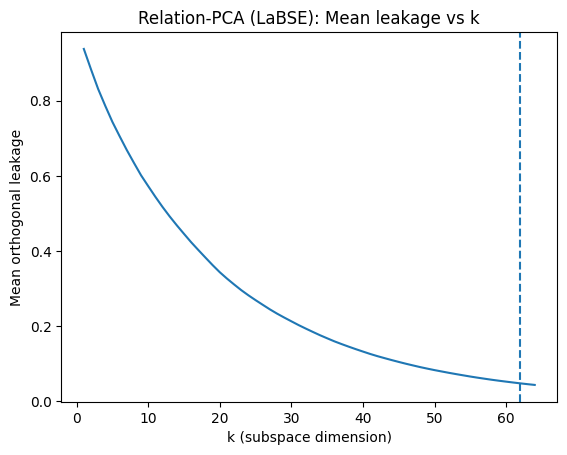

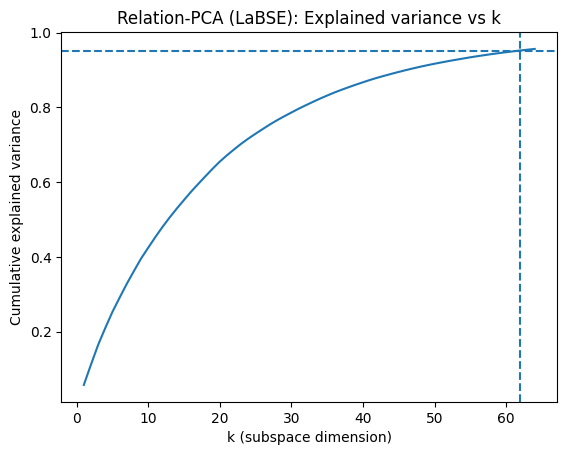

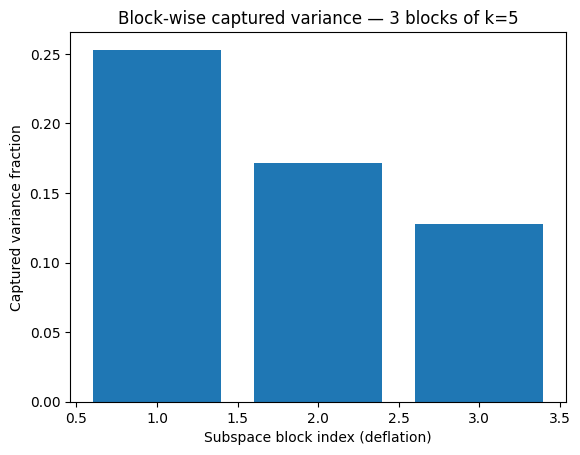

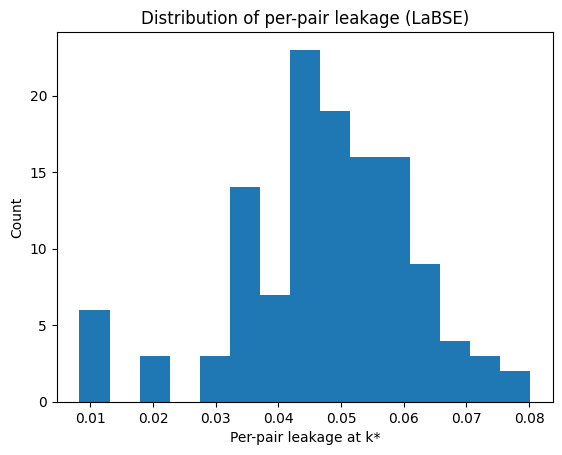

In [ ]:
# ========================= Charts =========================
plt.figure()
plt.plot(res["k_grid"], res["mean_leakage"])
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Mean orthogonal leakage")
plt.title("Relation-PCA (LaBSE): Mean leakage vs k")
plt.show()

plt.figure()
plt.plot(range(1, len(res["explained_variance_ratio"])+1), res["explained_variance_ratio"])
plt.axhline(VAR_TARGET, linestyle="--")
plt.axvline(k_star, linestyle="--")
plt.xlabel("k (subspace dimension)")
plt.ylabel("Cumulative explained variance")
plt.title("Relation-PCA (LaBSE): Explained variance vs k")
plt.show()

plt.figure()
plt.bar([bi["block_index"] for bi in block_info],
        [bi["captured_variance_fraction"] for bi in block_info])
plt.xlabel("Subspace block index (deflation)")
plt.ylabel("Captured variance fraction")
plt.title(f"Block-wise captured variance — {NUM_SUBSPACES} blocks of k={K_BLOCK}")
plt.show()

plt.figure()
plt.hist(pair_leak, bins=15)
plt.xlabel("Per-pair leakage at k*")
plt.ylabel("Count")
plt.title("Distribution of per-pair leakage (LaBSE)")
plt.show()

### **SONAR**

In [ ]:
print(torch.__version__)

2.8.0+cu126
